In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the dataset using Pandas
df = pd.read_csv('avocado.csv')
print(df.head())

   Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015 

In [21]:
# Map the "type" column to numerical values (0 for conventional, 1 for organic)
df['type'] = df['type'].map({'conventional': 0, 'organic': 1})

In [22]:
# Convert categorical "region" column to dummy variables
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)

In [23]:
# Convert "Date" column to datetime format and extract the month
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

In [24]:
# Create "Price Momentum" as the lagged average price by region
df['Price_Momentum'] = df.groupby('region')['AveragePrice'].shift(1)

In [26]:
# Avoid division by zero when calculating ratios
df['Volume_per_Bag'] = np.where(
    df['Total Bags'] > 0,
    df['Total Volume'] / df['Total Bags'],
    0
)
df['Small_Bags_Ratio'] = np.where(
    df['Total Bags'] > 0,
    df['Small Bags'] / df['Total Bags'],
    0
)
df['Large_Bags_Ratio'] = np.where(
    df['Total Bags'] > 0,
    df['Large Bags'] / df['Total Bags'],
    0
)

In [27]:
# Aggregate volume from specific PLU codes
df['Total_PLU_Volume'] = df['4046'] + df['4225'] + df['4770']

In [28]:
# Encode seasonal features using sine and cosine transformations
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [29]:
# Drop the original "region" column as it has been encoded
df.drop('region', axis=1, inplace=True)

In [30]:
# Feature list for the model
features = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 
           'Small_Bags_Ratio', 'Large_Bags_Ratio', 'type', 
           'year', 'month_sin', 'month_cos', 'Volume_per_Bag',
           'Total_PLU_Volume', 'Price_Momentum'] + list(region_dummies.columns)

In [31]:
# Fill missing values
df = df.ffill()

In [32]:
# Compute the correlation matrix
correlation_matrix = df[features].corr()

# Identify pairs of features with high correlation (> 0.8)
high_corr_features = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_features = [(features[x], features[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

# Remove one feature from each highly correlated pair
features_to_remove = set()
for feat1, feat2 in high_corr_features:
    features_to_remove.add(feat2)

# Final feature selection
selected_features = [f for f in features if f not in features_to_remove]

In [33]:
# Prepare the feature matrix (X) and target variable (y)
X = df[selected_features]
y = df['AveragePrice']

# Fill any remaining missing values in the feature matrix
X = X.ffill().bfill().fillna(0)

# Scale the features using RobustScaler to handle outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Transform the features into polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
# Dictionary to store the results
results = {}

def adjusted_r2(r2, n, p):
    """Calculate adjusted R-squared."""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [36]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

In [37]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2(r2, len(X_test), len(selected_features))

results['Linear Regression'] = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
    'Adjusted R2': adj_r2
}


Linear Regression Results:
------------------------
MAE: 0.0954
MSE: 0.0192
RMSE: 0.1385
R2: 0.8807
Adjusted R2: 0.8786


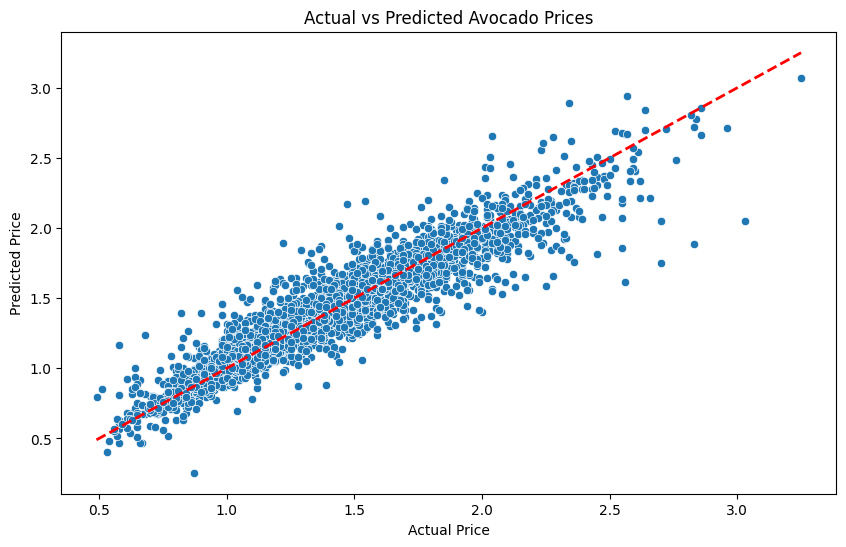

In [39]:
# Print the evaluation metrics
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print("------------------------")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Avocado Prices')
plt.show()
